In [2]:
import geocoder
from geopandas import GeoDataFrame
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


The Skyscraper Index (https://en.wikipedia.org/wiki/Skyscraper_Index) is sometimes used as a metric for determining the status of an economy, in particular, predicting when there will be an economic downturn.  The premise is that the tallest skyscrapers are built during times of economic growth, and this stops as the economy goes into recession.  There will be a lag, however, as construction projects are often finalised years in advance, contracts signed, and significant amounts of money have already been paid.  

You are going to investigate whether there is any evidence of the Skyscraper Index working empirically.

I have created a dataset containing 6000 skyscrapers.  This contains the name of the building, the city, the height in metres (and feet), the number of floors, the year of completion (or cancellation), and the status of the building (completed, under construction, cancelled, etc.).  

The dataset has been augmented by geocoding the cities and buildings.  The country, and the latitude and longitude of the city have been added.  The geocoding was done using OpenStreetMaps, which is free and community sourced - the accuracy of the data is not guaranteed.  In particular, the country names are returned in the official language of the country, and not English. 

This augmented dataset has been *partially* cleaned.  The country names have been converted to English, some missing fields have been added, and datatypes have been updated.  Each step of the cleaning is detailed in the notebook below. 

The Index also requires GDP data.  I have sourced a dataset for you from TODO, which contains several GDP metrics per country.  I have done some basic cleaning on the dataset too - something you will notice is that the country names do not align exactly with this dataset and the skyscraper dataset.  This is a normal problem you will run into when merging two disparate datasets.  I have detailed how I went about merging this, but it was a manual, once-off process.  


Questions: 
* For the buildings in the USA, create a chloropleth with the average height of all completed skyscrapers per state.  Hint:  look at the python osmnx package to do this. 
* Europe has relatively few skyscrapers, but their GDP per capita is high.  Look at the number of skyscrapers in Germany, France, UK, Switzerland, and the Netherlands.  Then compare this against the UAE, Japan, and the USA.  Can you provide a reason for why this is the case? 
* Look at the following 5 countries: SA, USA, UK, UAE, China.
* Look at the GDP per capita for these countries and plot this against a) the tallest building per year, b) the number of new skyscrapers built in a year, c) the number of cancelled buildings in a year.  
** Is there any obvious correlation between GDP and a), b) and c)?  You do not need to do any statistical tests - a couple of sentences is fine, just back it up with the data in the plot.  Any correlation metrics or plots would be beneficial.  Hint: look at the GDP *growth* as well. 
    ** Missing data: Not all buildings have a height.  How else can you show the height of the building?  
* For the chosen countries, find out when they had recessions, and add this as an additional point on the plot (single datapoint, you do not have to indicate the full length of the recession).  Is there any trend or correlation between the skyscraper data and the recessions?  As above, you only need to provide a written answer with motivation (and the source for the recession data - Wikipedia is fine).
* Of the 5 countries, 1 of the countries shows behaviour that is completely at odds with the Skyscraper Index.  Which one is it?  Any idea why?


Skyscraper data:

I have sourced this from https://en.phorio.com/?t=projectlist&collection=5495651&type=list.  You can try web-scraping it, but I scrolled down until there were 6000 results, and then copied the text into a text file, and wrote a small python script to clean it up for me and create a csv - see attached python script for the details. 

In [3]:
df = pd.read_csv('skyscrapers6000_clean.csv')
df.dropna(axis=0, subset=['City'], inplace=True)

The dataset contains the city, but not the country or coordinates.  I have geocoded these using the python package `geocoder`.  If you have an API key for Google or Bing maps, you can geocode with those services, but it is not free. 

In [4]:

def get_states():
    state_lookup = {}
    if os.path.exists('state_lookup.csv'):
        with open('state_lookup.csv', encoding="utf8") as fi:
            for ll in fi.readlines()[1:]:
                c,s = ll.strip().split(',')
                state_lookup[c] = s
        return state_lookup
    
    for city in df[df.Country == 'United States of America']['City'].unique():
        print(city)
        if city in state_lookup.keys():
            continue
        c = geocoder.osm(city)
        if not c.ok: 
            continue
        state_lookup[city] = c.state

    with open('state_lookup.csv', 'w', encoding="utf8") as fo:
        fo.write('city,state\n')
        for c, s in state_lookup.items():
            fo.write(c + ',' + s + '\n')
    return state_lookup


def geocode_it():
    city_lookup = {}
    # if the geocoding has already been done, just read in the file.
    if os.path.exists('city_lookup.csv'):
        with open('city_lookup.csv', 'r', encoding="utf8") as fi:
            for ci in fi.readlines()[1:]:
                city, cntry, lat, lon, cntry_eng = ci.strip().split(',')
                city_lookup[city] = {
                    'Country': cntry,
                    'Latitude': float(lat),
                    'Longitude': float(lon)
                }
        return city_lookup

    counter = 0
    for _, row in df.iterrows():
        if counter % 100 == 0:
            print(counter)
        counter += 1
        city = row['City']
        # do not geocode a city that has been geocoded already
        if city in city_lookup.keys():
            continue

        bldg = row['Building']
        g = geocoder.osm(city)
        # if it could not find details for the city only, then try adding in the building name too.
        if not g.ok:
            print('could not get country for ', city, 'trying with building')
            g = geocoder.osm(bldg + ', ' + city)
            if not g.ok:
                print('could not get country for ', city, bldg)
                
        city_lookup[city] = {'Country': g.country, 'Latitude': g.latlng[0], 'Longitude': g.latlng[1]}

    # save the output so that next time we don't have to do all the geocoding again! 
    with open('city_lookup.csv', 'w', encoding="utf8") as fo:
        fo.write('city,country,latitude,longitude\n')
        for city, vals in city_lookup.items():
            fo.write(str(city) + ',' + str(vals['Country']) +',' + str(vals['Latitude']) + ',' + str(vals['Longitude']) + '\n')

    return city_lookup

city_lookup = geocode_it()
state_lookup = get_states()

If you check the unique country names, you'll notice that they are not in English. 

In [5]:
unique_countries = list(set([x['Country'] for x in city_lookup.values()]))

Now, this is where you have to do a bit of digging in the data exploration process.  I created a dictionary with the translation to English - where it was not obvious to me, I used Google Translate to get the translation (eg. for Pakistan, South Korea and North Korea). 

Note here name for Taiwan.  This is a contentious political issue...  For the mapping between the skyscraper dataset and the GDP dataset, we are going to include Taiwan as part of China. 

In [6]:
english_names = {
    '북조선': 'North Korea',
    'قطر Qatar': 'Qatar',
    'Saudi Arabia / السعودية': 'Saudi Arabia',
    'Česká republika': 'Czech Republic',
    'República Dominicana': 'Dominican Republic',
    'Magyarország': 'Hungary',
    'Norge': 'Norway',
    'Polska': 'Poland',
    'België - Belgique - Belgien': 'Belgium',
    'پاکستان': 'Pakistan',
    'Maroc': 'Morocco',
    'Nederland': 'Netherlands',
    'България': 'Bulgaria',
    'Shqipëria': 'Albania',
    '日本 (Japan)': 'Japan',
    'Россия': 'Russia',
    'Македонија': 'Macedonia',
    'Latvija': 'Latvia',
    'Georgia / საქართველო': 'Georgia',
    'México': 'Mexico',
    'Lëtzebuerg': 'Luxembourg',
    'Sverige': 'Sweden',
    'Lietuva': 'Lithuania',
    'Κύπρος': 'Cyprus',
    'Deutschland': 'Germany',
    'Việt Nam': 'Vietnam',
    'ประเทศไทย': 'Thailand',
    'Bosna i Hercegovina': 'Bosnia and Herzegovina',
    '대한민국': 'South Korea',
    'Ελλάδα': 'Greece',
    'ایران': 'Iran',
    'Србија (Serbia)': 'Serbia',
    'Danmark': 'Denmark',
    'Беларусь': 'Belarus',
    'Österreich': 'Austria',
    'Egypt / مصر': 'Egypt',
    'Україна': 'Ukraine',
    'Slovensko': 'Slovenia',
    'Türkiye': 'Turkey',
    'البحرين': 'Bahrain',
    'Eesti': 'Estonia',
    'لبنان  Lebanon': 'Lebanon',
    'Jordan / الأُرْدُن': 'Jordan',
    'Kuwait / الكويت': 'Kuwait',
    'Italia': 'Italy',
    'România': 'Romania',
    'China 中国': 'China',
    'Brasil': 'Brazil',
    'España': 'Spain',
    'ישראל': 'Israel',
    'Taiwan': 'China'
}

In [7]:
for city in city_lookup.keys():
    if city_lookup[city]['Country'] in english_names.keys():
        city_lookup[city]['Country_English'] = english_names[city_lookup[city]['Country']]
    else:
        city_lookup[city]['Country_English'] = city_lookup[city]['Country']

In [8]:
# Now, we can add these new details to our original skyscraper dataset
for col in ['Country', 'Country_English', 'Latitude', 'Longitude']:
    df[col] = df['City'].apply(lambda x: city_lookup[x][col])
 
state_lookup = get_states()
df['State'] = df['City'].apply(lambda x: state_lookup.get(x, 'N/A'))
    
# Weirdly, when looking at the data manually, I discovered that the geocoding for Cologne did not work, so I filled it in manually. 
df.loc[df['City'] == 'Cologne', 'Country_English'] = 'Germany'

There was a bit of cleaning that had to be done on the original skyscraper dataset.  For some of the buildings, there was missing data for the heights, but when reading it in, I noticed that it actually shifted some of the columns left.  So, `Height m` had the `Floors`, `Height ft` had the `Year`, and `Floors` had the `Status`.

In [9]:
df['Height m'] = df['Height m'].str.replace(' m', '')
df['Height ft'] = df['Height ft'].str.replace(' ft', '')

In [10]:
missing_heights = df[df['Status'].isnull()].index

df.loc[missing_heights, 'Status'] = df.loc[missing_heights, 'Floors'].copy()
df.loc[missing_heights, 'Floors'] = df.loc[missing_heights, 'Height m']
df.loc[missing_heights, 'Year'] = df.loc[missing_heights, 'Height ft']
df.loc[missing_heights, 'Height m'] = 0
df.loc[missing_heights, 'Height ft'] = 0

In [11]:
# Here I've converted all the datatypes to floats and ints, as appropriate.  Note that this does not work if you have null values - hence filling in Floors with "0 floors". 
df['Height m'] = df['Height m'].astype(np.float)
df['Height ft'] = df['Height ft'].astype(np.float)
df['Floors'].fillna("0 floors", inplace=True)
df['Floors'] = df['Floors'].str.replace(' floors', '')#.astype(np.int)
df['Floors'] = df.Floors.astype(np.int)



In [ ]:
###### This is where you can plot your chloropleth

GDP data:

I sourced this from the Worldbank website (https://datacatalog.worldbank.org/dataset/world-development-indicators).  I extracted the indicators below for each country, and have saved in `gdp.csv`.  It contains the GDP values below for over 200 economies between 1960 and 2019.  You'll notice that there are several missing years for certain countries.  This again, is typical when working with datasets from multiple sources.  Not all countries release their data, and if they do, they might not provide the results in a similar manner to other countries.  I do not expect you to fill in the missing data here.  Only work with what is here! Eg. UAE only has GDP data from the mid-70s onwards.  That's fine, focus on this period onwards for UAE.  


In [12]:
dfg = pd.read_csv('gdp.csv', encoding='latin-1')
    
indicators = {
    'GDP (current US$)': 'NY.GDP.MKTP.CD', 
    'GDP growth (annual %)': 'NY.GDP.MKTP.KD.ZG',
    'GDP per capita (current US$)': 'NY.GDP.PCAP.CD', 
    'GDP per capita growth (annual %)': 'NY.GDP.PCAP.KD.ZG',
    'GDP per capita, PPP (current international $)': 'NY.GDP.PCAP.PP.CD',
    'GDP, PPP (current international $)': 'NY.GDP.MKTP.PP.CD'
}
years = [str(1960 + x) for x in range(60)]

The countries have different names between the two datasets.  I looked at which countries in the skyscraper dataset do not exist in the GDP dataset, and manually tried to correct for them.  Not all countries were in the GDP dataset, and some had different variations on the name.  

Note for N. Koreas and Cote d'Ivoire, the difference also includes a special character!!! This happens, but you just need to be aware of it.

In [13]:
df[~df['Country_English'].isin(dfg['Country Name'])]['Country_English'].unique()

gdp_mapping = {
    'United States': 'United States of America',
    'Russian Federation': 'Russia',
    'Korea, Rep.': 'South Korea',
    'Iran, Islamic Rep.': 'Iran',
    'Venezuela, RB': 'Venezuela',
    'Korea, Dem. People\x92s Rep.': 'North Korea',
    'North Macedonia': 'Macedonia',
    "Cote d'Ivoire": "Côte d'Ivoire",
}

In [14]:
for g in gdp_mapping.keys():
    dfg.loc[dfg['Country Name'] == g, 'Country Name'] = gdp_mapping[g]

In [15]:
# now, you will notice there are only a handful of those which do not match. We can ignore these... 
df[~df['Country_English'].isin(dfg['Country Name'])]

,Row,Building,City,Height m,Height ft,Floors,Year,Status,Country,Country_English,Latitude,Longitude,State
573,574,Majakka,Helsinki,131.7,432.09,35,2019,completed,Suomi,Suomi,60.167410,24.942577,N/A
1071,1072,Martin Tower,Bethlehem,101.2,332.00,21,1972,destroyed,Palestinian Territory,Palestinian Territory,31.704356,35.206188,N/A
2179,2180,Lumo One,Helsinki,120.5,395.34,31,NaN,frame assembly,Suomi,Suomi,60.167410,24.942577,N/A
2390,2391,Loisto,Helsinki,124.0,406.82,32,NaN,topped out,Suomi,Suomi,60.167410,24.942577,N/A
2791,2792,Hotelli Tähtitorni,Tampere,141.0,462.60,40,NaN,canceled,Suomi,Suomi,61.498021,23.760312,N/A
3061,3062,Gaza Twin Tower I,Gaza,150.0,492.13,36,NaN,proposed,Palestinian Territory,Palestinian Territory,31.433166,34.377929,N/A
5007,5008,Glaðheimar Turn,Kópavogur,115.0,377.30,32,NaN,approved,Ísland,Ísland,64.028044,-21.686270,N/A
5659,5660,Vattanac Capital Tower,Phnom Penh,187.3,614.50,39,2013,completed,Cambodia,Cambodia,11.573039,104.857807,N/A


<Figure size 432x288 with 0 Axes>

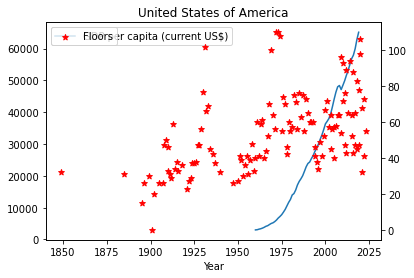

<Figure size 432x288 with 0 Axes>

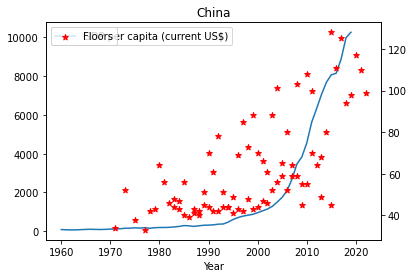

<Figure size 432x288 with 0 Axes>

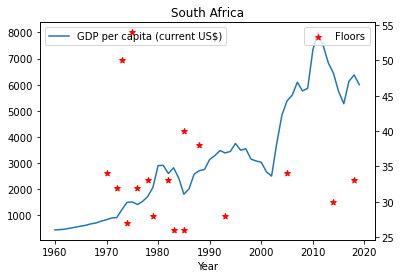

<Figure size 432x288 with 0 Axes>

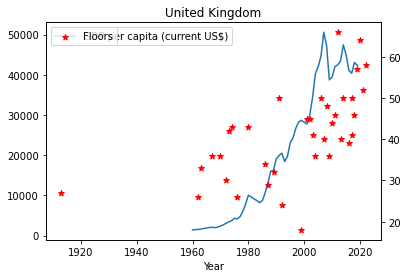

<Figure size 432x288 with 0 Axes>

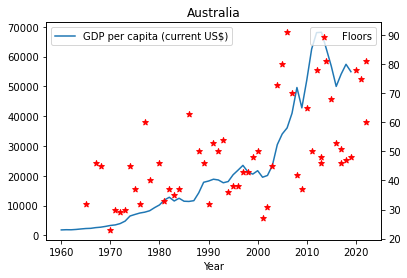

<Figure size 432x288 with 0 Axes>

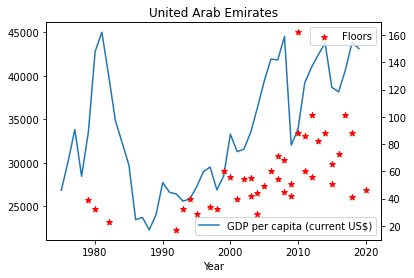

In [132]:
def plot_it(gdp_data, bldg_data, country, key, indicator):
    plt.clf()
    fig, ax = plt.subplots()
    gdp_data.plot(x='Year', y=indicator, ax=ax, label=indicator)
    ax2 = ax.twinx()
    plt.scatter(x=bldg_data['Year'], y=bldg_data[key], color='red', marker='*', label=key)
    plt.title(country)
    plt.legend()
    plt.show()

    
countries = ['United States of America', 'China', 'South Africa', 'United Kingdom', 'Australia', 'United Arab Emirates']
indicator = 'GDP per capita (current US$)'  # 'GDP per capita growth (annual %)'
indicator_cd = indicators[indicator]

for country in countries:
    key = 'Floors'
    num_bldgs = df[(df['Country_English'] == country)].groupby('Year').Building.count().reset_index()
    max_height = df[(df['Country_English'] == country)].groupby('Year')[key].max().reset_index()
    max_height['Year'] = max_height['Year'].astype(np.int)
    dfsa = dfg[(dfg['Country Name'] == country) & (dfg['Indicator Code'] == indicator_cd)][years].T.reset_index()
    
    dfsa.columns=['Year', indicator]
    dfsa.Year = dfsa.Year.astype(np.int)
    plot_it(dfsa, max_height, country, key, indicator)

### Question 3.1

In [18]:
df_usa = df[df['Country_English'] == 'United States of America']
df_usa = df_usa[df_usa['Status'] == 'completed']

df_usa.head()

,Row,Building,City,Height m,Height ft,Floors,Year,Status,Country,Country_English,Latitude,Longitude,State
2,3,Empire State Building,New York City,381.01,1250.02,102,1931,completed,United States of America,United States of America,40.712728,-74.006015,New York
4,5,Chrysler Building,New York City,318.92,1046.31,77,1930,completed,United States of America,United States of America,40.712728,-74.006015,New York
5,6,Lake Point Tower,Chicago,196.60,645.01,70,1968,completed,United States of America,United States of America,41.875562,-87.624421,Illinois
7,8,875 North Michigan,Chicago,343.69,1127.58,100,1969,completed,United States of America,United States of America,41.875562,-87.624421,Illinois
9,10,Hearst Tower,New York City,181.97,597.01,46,2006,completed,United States of America,United States of America,40.712728,-74.006015,New York


In [19]:
df_usa_mean_height = pd.DataFrame(df_usa.groupby('State')['Height m'].mean(), index=None)
df_usa_mean_height = df_usa_mean_height.to_dict()

In [20]:
# cities; Plot 'New York', 'Los Angeles', 'Chicago', 'San Francisco' and 'Seattle' 'Los Angeles'
df_usa_city = df_usa[(df_usa.City == 'New York') | (df_usa.City == 'Los Angeles') | (df_usa.City == 'Chicago')| (df_usa.City == 'San Francisco') | (df_usa.City == 'Seattle')| (df_usa.City == 'Los Angeles')]
df_usa_city_height = pd.DataFrame(df_usa_city.groupby('City')['Height m'].max(), index=None)

In [21]:
import plotly.express as px

In [22]:
# load json file
usa_state_json = json.load(open('USA_states_geojson.json'))
# returns geodataframe:
usa_df_geo = GeoDataFrame.from_features(usa_state_json['features'])
usa_df_geo = usa_df_geo[["NAME", "geometry"]]
usa_df_geo = usa_df_geo.rename(columns={"NAME": "State"})

# set average tables using dict created in prev cell
avg_heights_list = []
for state in usa_df_geo.State:
    if state in df_usa_mean_height['Height m'].keys():
        avg_heights_list.append(df_usa_mean_height['Height m'][state])
    else:
        avg_heights_list.append(0)
        
        
usa_df_geo["Average height m"] = avg_heights_list
usa_df_geo.set_index(usa_df_geo.State, inplace=True)

In [24]:
fig = px.choropleth(usa_df_geo, geojson=usa_df_geo.geometry, locations=usa_df_geo.index, 
                        color='Average height m',
                           color_continuous_scale='turbo',
                           range_color=(0, max(avg_heights_list)),
                           scope="usa",
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

ValueError: 
    Invalid value of type 'builtins.str' received for the 'colorscale' property of make_figure
        Received value: 'turbo'

    The 'colorscale' property is a colorscale and may be
    specified as:
      - A list of colors that will be spaced evenly to create the colorscale.
        Many predefined colorscale lists are included in the sequential, diverging,
        and cyclical modules in the plotly.colors package.
      - A list of 2-element lists where the first element is the
        normalized color level value (starting at 0 and ending at 1),
        and the second item is a valid color string.
        (e.g. [[0, 'green'], [0.5, 'red'], [1.0, 'rgb(0, 0, 255)']])
      - One of the following named colorscales:
            ['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
             'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
             'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
             'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
             'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
             'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
             'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
             'orrd', 'oryel', 'peach', 'phase', 'picnic', 'pinkyl', 'piyg',
             'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn', 'puor',
             'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu', 'rdgy',
             'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar', 'spectral',
             'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn', 'tealrose',
             'tempo', 'temps', 'thermal', 'tropic', 'turbid', 'twilight',
             'viridis', 'ylgn', 'ylgnbu', 'ylorbr', 'ylorrd'].
        Appending '_r' to a named colorscale reverses it.


In [25]:
usa_county_json = json.load(open('gz_2010_us_050_00_500k.json'))
usa_county_geo = GeoDataFrame.from_features(usa_county_json['features'])
usa_county_geo = usa_county_geo[["NAME", "geometry"]]
usa_county_geo = usa_county_geo.rename(columns={"NAME": "County"})
usa_county_geo

,County,geometry
0,Cleburne,"POLYGON ((-85.38872 33.91304, -85.38089 33.873..."
1,Coffee,"POLYGON ((-86.03044 31.61894, -86.00409 31.619..."
2,Coosa,"POLYGON ((-86.00928 33.10164, -86.00917 33.090..."
3,Covington,"POLYGON ((-86.34851 30.99434, -86.35023 30.994..."
4,Crenshaw,"POLYGON ((-86.14699 31.68045, -86.14711 31.663..."
...,...,...
3216,San Sebastián,"POLYGON ((-66.90748 18.25314, -66.90739 18.253..."
3217,Santa Isabel,"POLYGON ((-66.37968 17.94399, -66.38029 17.943..."
3218,Toa Baja,"MULTIPOLYGON (((-66.13957 18.46232, -66.13956 ..."
3219,Trujillo Alto,"POLYGON ((-66.02917 18.37590, -66.02828 18.376..."


In [26]:
states = []
geomerty = []
for i in df_usa_city_height.to_dict()['Height m'].keys():
    if i in usa_county_geo.County:
        print(i)

In [27]:
Cities = []
geometry = []
for i in usa_county_geo.set_index("County").to_dict()['geometry'].keys():
    if i in df_usa_city_height.to_dict()['Height m'].keys():
        #print(i, usa_county_geo.set_index("County").to_dict()['geometry'][i])
        Cities.append(i)
        geomerty.append(usa_county_geo.set_index("County").to_dict()['geometry'][i])
        


In [28]:
pd.Dat{'Cities': Cities, 'geometry': geometry} # fix

SyntaxError: invalid syntax (<ipython-input-28-f2100da119bf>, line 1)

### Question 3.2

In [29]:
#df.Country[['Germany', 'France', 'UK', 'Switzerland', 'Netherlands']]

df[((df.Country_English == 'Germany') & (df.Country_English == 'France'))]#& (df.Country == 'UK') & (df.Country == 'Switzerland') & (df.Country == 'Netherlands'))

,Row,Building,City,Height m,Height ft,Floors,Year,Status,Country,Country_English,Latitude,Longitude,State


In [30]:
df_europe_skyscrappers = df[(df.Country_English == 'Germany') | (df.Country_English == 'France') | (df.Country_English == 'UK') | (df.Country_English == 'Switzerland') | (df.Country == 'Netherlands')]

In [31]:
# number of skyscrappers
df_europe_skyscrappers.groupby('Country_English')['Row'].count()

Country_English
France          95
Germany        151
Switzerland      3
Name: Row, dtype: int64

In [32]:
#UAE, Japan, and the USA
df_uae_jpn_usa = df[(df.Country_English == 'United Arab Emirates') | (df.Country_English == 'Japan') | (df.Country_English == 'United States of America')]
df_uae_jpn_usa.groupby('Country_English')['Row'].count()

Country_English
Japan                        304
United Arab Emirates         235
United States of America    1990
Name: Row, dtype: int64

Number of skyscrappers per country is shown above. Japan, UAE and USA have 2529 skyscrappers in total. France, Germany and Switzerland have 249 skyscrappers in total. The reason for this is that some European have more or less strict regulations that prevent the construction of high rise buildings. In the 19th Century, skyscrapers first rose to prominence in USA and many European cities were already firmly established with grand historic buildings and public spaces that left little room for large new structures. European cities in the 21st century still try to peserve these historical buildings. 

Japan, UAE and USA have a relatively high population density compared to European countries. Japan's population density was 320 people per square kilometer as of 1984, while France's population density is 100.10. The vast majority of Europe's urban communities around that time were also more evenly zoned and were not facing the high demand for floor space in key districts that typically drive high rise development.

### Question 3.3.2

In [33]:
df

,Row,Building,City,Height m,Height ft,Floors,Year,Status,Country,Country_English,Latitude,Longitude,State
0,1,HSB Turning Torso,Malmö,190.00,623.36,57,2005,completed,Sverige,Sweden,55.605293,13.000157,N/A
1,2,30 St Mary Axe,London,179.80,589.90,41,2003,completed,United Kingdom,United Kingdom,51.507322,-0.127647,N/A
2,3,Empire State Building,New York City,381.01,1250.02,102,1931,completed,United States of America,United States of America,40.712728,-74.006015,New York
3,4,Commerzbank Tower,Frankfurt am Main,259.00,849.74,58,1997,completed,Deutschland,Germany,50.110644,8.682092,N/A
4,5,Chrysler Building,New York City,318.92,1046.31,77,1930,completed,United States of America,United States of America,40.712728,-74.006015,New York
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,5996,Fortune Center Residential Tower 1,Liuzhou,210.00,688.98,60,2016,completed,China 中国,China,25.000999,109.341425,N/A
5996,5997,Suseong Leader's View 2,Daegu,225.00,738.19,57,2010,completed,대한민국,South Korea,35.871300,128.601800,N/A
5997,5998,Horto Bela Vista Torre Residencial 10,Salvador,0.00,0.00,44,NaN,approved,El Salvador,El Salvador,13.800038,-88.914068,N/A
5998,5999,Denny Playfield Residential Tower,Seattle,0.00,0.00,41,NaN,proposed,United States of America,United States of America,47.603832,-122.330062,Washington


In [41]:
#usa: 2008
#south africa: 2008, 2009, 2018
#uk: 2008
#uae:2020
#australia: 1990
#china: 1949
df_RSA = df[df['Country_English'] == 'South Africa']
df_RSA = df_RSA[df_RSA['Status'] == 'completed']

df_uk = df[df['Country_English'] == 'United Kingdom']
df_uk = df_uk[df_uk['Status'] == 'completed']

df_uae = df[df['Country_English'] == 'United Arab Emirates']
df_uae = df_uae[df_uae['Status'] == 'completed']

df_china = df[df['Country_English'] == 'China']
df_china = df_china[df_china['Status'] == 'completed']

<Figure size 432x288 with 0 Axes>

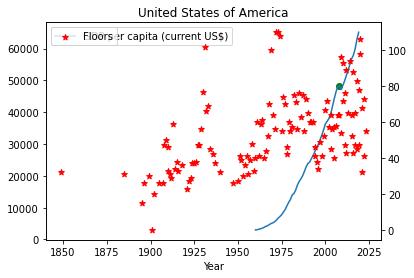

<Figure size 432x288 with 0 Axes>

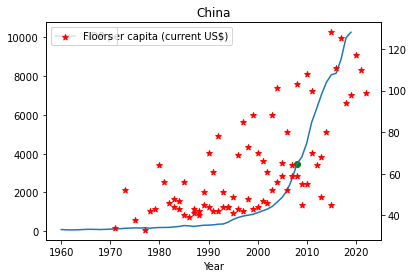

<Figure size 432x288 with 0 Axes>

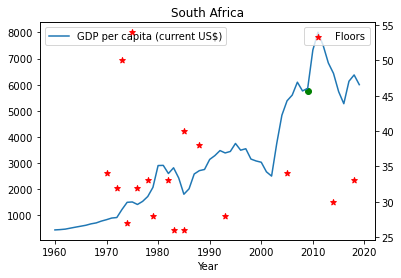

<Figure size 432x288 with 0 Axes>

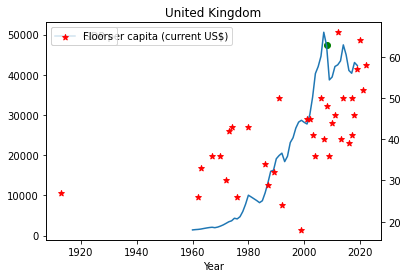

<Figure size 432x288 with 0 Axes>

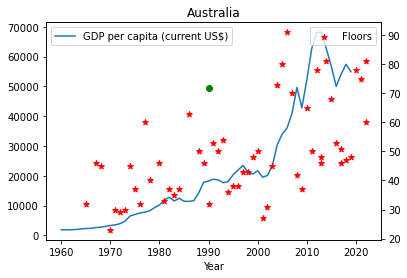

<Figure size 432x288 with 0 Axes>

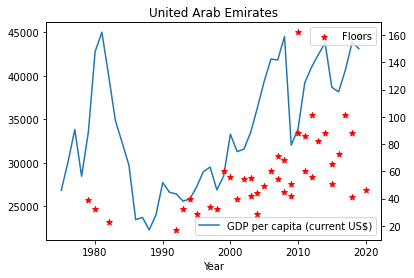

In [140]:
def plot_it(gdp_data, bldg_data, country, key, indicator, year, gdp):
    plt.clf()
    fig, ax = plt.subplots()
    plt.scatter(x=year, y=gdp, color='green')
    gdp_data.plot(x='Year', y=indicator, ax=ax, label=indicator)
    ax2 = ax.twinx()
    plt.scatter(x=bldg_data['Year'], y=bldg_data[key], color='red', marker='*', label=key)
    plt.title(country)
    plt.legend()
    plt.show()

    
countries = ['United States of America', 'China', 'South Africa', 'United Kingdom', 'Australia', 'United Arab Emirates']
indicator = 'GDP per capita (current US$)'  # 'GDP per capita growth (annual %)'
year_of_rec = [2008, 2008, 2009, 2008, 1990, 2019 ]
gdp_rec = [48382.55845, 3468.304463, 5760.805287, 47286.99849, 49601.65671, 44498.93423 ]
count = 0
indicator_cd = indicators[indicator]

for country in countries:
    key = 'Floors'
    num_bldgs = df[(df['Country_English'] == country)].groupby('Year').Building.count().reset_index()
    max_height = df[(df['Country_English'] == country)].groupby('Year')[key].max().reset_index()
    max_height['Year'] = max_height['Year'].astype(np.int)
    dfsa = dfg[(dfg['Country Name'] == country) & (dfg['Indicator Code'] == indicator_cd)][years].T.reset_index()
    
    dfsa.columns=['Year', indicator]
    dfsa.Year = dfsa.Year.astype(np.int)
    plot_it(dfsa, max_height, country, key, indicator, year_of_rec[count], gdp_rec[count])
    count += 1

- Yes, the recession often occurs when the GDP of the country has grown for a few years without interruptions. 

In [141]:
# The data was found at Wikipedia
# Recession
# SA: http://www.statssa.gov.za/?p=13049#:~:text=The%20first%20recession%20since%201994,Q1%20and%20Q2%20of%202018.
# china: https://www.forbes.com/sites/yuwahedrickwong/2020/03/10/a-china-centric-global-recession/?sh=1673c61d71ad
# uk: https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_Kingdom
# UAE: https://gulfnews.com/business/global-economic-recession-will-be-deep-but-wont-last-for-long-1.72123764
# Australia: https://en.wikipedia.org/wiki/Economic_history_of_Australia
# USA: https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States
# Everyone had a covid-19 recession, that would not be fair to view as pandemic affected everyone. 

### 3.3.3

- South Africa. As the economy grew, especially from the early 2000 we saw less and less skyskrapers being built.
- Cause: Post the apartheid era, there has been a lot of money spent towards improving the entire country rather than focus on a certain portion of the citizens. Money is being invested in developing the entire country.